# 2020 USA Presidential Election Twitter Pipeline - Sentiment Classifier 

## Author: André Godinho

LinkedIn: https://www.linkedin.com/in/andregodinho97/

Github: https://github.com/AndreGodinho7

## 1. Install packages

In [ ]:
!pip install transformers==3.0.0
!pip install torch
!pip install pandas
!pip install numpy 
!pip install matplotlib
!pip install seaborn
!pip install torch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


## 2. Imports

In [57]:
from BERT import BERT
from BERTFormatDataloader import BERTFormatDataloader
from BERTSentimentClassifier import BERTSentimentClassifier
from SentimentFineTuning import SentimentFineTuning

from MyData import MyData
from BERTFormatDataset import BERTFormatDataset

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch import nn, optim
import numpy as np
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


sns.set()

## 3. Constants


In [29]:
RANDOM_SEED = 10
MAX_LEN = 160
BATCH_SIZE = 16
n_GPU = 1
EPOCHS = 10
CLASSES = 3

MODEL_NAME = 'reviews_bert_classifier'
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/'+MODEL_NAME+'.bin'
TRAIN_FLAG = True
LOAD_MODEL = False

## 4. Setup

In [20]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 5. Load data

In [6]:
data = MyData("data/sentiments.csv")
df_data = data.getData()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
 11  sentiment             15746 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 1.4+ MB


In [7]:
df_data.head(3)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0


2    5676
1    5042
0    5028
Name: sentiment, dtype: int64


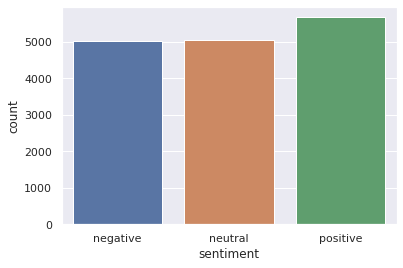

In [8]:
class_names = ['negative', 'neutral', 'positive']
print(df_data.sentiment.value_counts())
ax = sns.countplot(df_data.sentiment)
ax.set_xticklabels(class_names)
plt.rcParams['figure.figsize'] = (4,4)

## 6. Train test split 

In [9]:
train, test = train_test_split(
  df_data,
  test_size=0.1,
  random_state=RANDOM_SEED
)

val, test = train_test_split(
  test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

print(f'Train size: {train.shape}, Val size: {val.shape}, Test size: {test.shape}')

Train size: (14171, 12), Val size: (787, 12), Test size: (788, 12)


## 7. Sentiment Classifier: BERT base


In [10]:
bert = BERT(CLASSES)
bert_sentiment_classifier = BERTSentimentClassifier(bert, device)

## 8. BERT Format Dataset and Dataloader


In [11]:
train_dataset = BERTFormatDataset(train, MAX_LEN)
val_dataset = BERTFormatDataset(val, MAX_LEN)
test_dataset = BERTFormatDataset(test, MAX_LEN)

In [12]:
train_dataloader = BERTFormatDataloader(train_dataset, BATCH_SIZE, n_GPU).getDataloader()
val_dataloader = BERTFormatDataloader(val_dataset, BATCH_SIZE, n_GPU).getDataloader()
test_dataloader = BERTFormatDataloader(test_dataset, BATCH_SIZE, n_GPU).getDataloader()

## 9. Optimizer, Scheduler and Loss function choice 


In [13]:
optimizer = AdamW(bert.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

## 10. Training loop


In [14]:
%%time

if TRAIN_FLAG:
  print("Fine-tuning is starting ...")
  name = 'reviews_bert_classifier'
  fine_tuner = SentimentFineTuning(optimizer=optimizer, device=device, scheduler=scheduler, loss_fn=loss_fn, len_train=len(train), len_val=len(val))
  results = fine_tuner.trainloop(bert_sentiment_classifier, train_dataloader, val_dataloader, EPOCHS, name)

else:
  print("Training flag is disabled, please enable TRAIN_FLAG.")

Epoch: 1/10
----------
Train accuracy: 0.6744054759720556 Train loss: 0.7186506838951907 
Val   accuracy: 0.7445997458703939

Epoch: 2/10
----------
Train accuracy: 0.8427069367017148 Train loss: 0.4144331709046598 
Val   accuracy: 0.8271918678526049

Epoch: 3/10
----------
Train accuracy: 0.9231529179309859 Train loss: 0.23465395103756373 
Val   accuracy: 0.8564167725540026

Epoch: 4/10
----------
Train accuracy: 0.9553313104226943 Train loss: 0.15464776387421358 
Val   accuracy: 0.8602287166454893

Epoch: 5/10
----------
Train accuracy: 0.9707148401665373 Train loss: 0.1073948377154717 
Val   accuracy: 0.8703939008894537

Epoch: 6/10
----------
Train accuracy: 0.9772069719850399 Train loss: 0.0788137378403917 
Val   accuracy: 0.866581956797967

Epoch: 7/10
----------
Train accuracy: 0.9816526709477101 Train loss: 0.06289331224076497 
Val   accuracy: 0.8703939008894537

Epoch: 8/10
----------
Train accuracy: 0.9842636370051514 Train loss: 0.05141924313624911 
Val   accuracy: 0.8716645

## 11. Loading model

In [54]:
if LOAD_MODEL:
  print("Loading fine-tuned model...")
  fine_tuned_weights = torch.load(MODEL_PATH)
  model = BERT(CLASSES)
  model.load_state_dict(fine_tuned_weights)
  bert_sentiment_classifier = BERTSentimentClassifier(model, device)
  print("Model has been loaded.")

else:
  print("LOAD_MODEL flag is disabled.")

Loading fine-tuned model...
Model has been loaded.


## 12. Evaluate on test set

In [ ]:
y_messages, y_pred, y_pred_probs, y_test = bert_sentiment_classifier.predict_results(data_loader=test_dataloader, device=device))
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## 13. Example of a prediction

In [ ]:
idx = 4
message = y_messages[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(message)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Sentiment')
plt.xlabel('Probability')
plt.xlim([0, 1]);

## 14. References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

- [Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/#skip-nav)

- [Huggingface Transformers](https://huggingface.co/transformers/)
